In [1]:
import pandas as pd
import numpy as np
import keras
import scipy
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.model_selection import GroupKFold
from sklearn import linear_model
from lineartree import RandomForestRegressor
from sklearn import metrics
from scipy.signal import savgol_filter
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [2]:
from numpy.random import seed
seed(1)
from tensorflow.keras.utils import set_random_seed
set_random_seed(2)

In [3]:
def rae(actual, predicted):
    actual = np.asarray(actual).reshape(-1,1)
    predicted = np.asarray(predicted).reshape(-1,1)
    numerator = np.sum(np.abs(predicted - actual))
    denominator = np.sum(np.abs(np.mean(actual) - actual))
    return numerator / denominator

In [4]:
def peak_eV_nm(peak_eV):
    peak_eV = np.asarray(peak_eV).reshape(-1,1)
    return 1239.84193/peak_eV

In [5]:
def FWHM_eV_nm(peak_eV,fwhm_eV):
    peak_eV = np.asarray(peak_eV).reshape(-1,1)
    fwhm_eV = np.asarray(fwhm_eV).reshape(-1,1)
    return  2*(1239.84193/(peak_eV-fwhm_eV/2) - 1239.84193/(peak_eV))

In [6]:
def predict_dist(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    return np.hstack(preds)

In [7]:
def predict_point(X, model, num_samples):
    pred_dist = predict_dist(X, model, num_samples)
    return pred_dist.mean(axis=1)

In [8]:
#Define models

initializer = keras.initializers.HeNormal(seed=1)
opt = keras.optimizers.Adam(learning_rate=0.001)

model_peak = keras.models.Sequential()
model_peak.add(Dense(5, input_shape=(5,), kernel_initializer=initializer, activation='relu'))
model_peak.add(Dense(50,  activation='relu'))
model_peak.add(keras.layers.Dropout(0.2))
model_peak.add(Dense(50,  activation='relu'))
model_peak.add(keras.layers.Dropout(0.2))
model_peak.add(Dense(1, kernel_initializer=initializer))
# Compile model
model_peak.compile(loss='mean_squared_error', optimizer= opt)

model_fwhm = keras.models.Sequential()
model_fwhm.add(Dense(5, input_shape=(5,), kernel_initializer=initializer, activation='relu'))
model_fwhm.add(Dense(50,  activation='relu'))
model_fwhm.add(keras.layers.Dropout(0.2))
model_fwhm.add(Dense(50,  activation='relu'))
model_fwhm.add(keras.layers.Dropout(0.2))
model_fwhm.add(Dense(1, kernel_initializer=initializer))
# Compile model
model_fwhm.compile(loss='mean_squared_error', optimizer= opt)

model_cascade = keras.models.Sequential()
model_cascade.add(Dense(6, input_shape=(6,), kernel_initializer=initializer, activation='relu'))
model_cascade.add(Dense(50,  activation='relu'))
model_cascade.add(keras.layers.Dropout(0.2))
model_cascade.add(Dense(50,  activation='relu'))
model_cascade.add(keras.layers.Dropout(0.2))
model_cascade.add(Dense(1, kernel_initializer=initializer))
# Compile model
model_cascade.compile(loss='mean_squared_error', optimizer= opt)


In [9]:
# Train model on entire dataset (Absorbance)
# load dataset into Pandas DataFrame (cleaned UV data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

matrix = np.zeros([1,8])
matrix_fwhm = np.zeros([1,8])
matrix_cascade = np.zeros([1,8])

#Separate out training and test sets (in this case they are the same)
X_train = X
X2_train = X2
y_train = y
z_train = z
X_test = X
X2_test = X2
y_test = y
z_test = z
j=0

#Initialize with fixed weights
model_peak.load_weights('initialize_weights3.h5')
model_fwhm.load_weights('initialize_weights3.h5')
model_cascade.load_weights('initialize_weights4.h5')

#Train models
#prediction for Peak
model_peak.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test),verbose = 1, use_multiprocessing=False, workers = 100)
y_pred = model_peak.predict(X_test)
#prediction for FWHM (direct)
model_fwhm.fit(X_train, z_train, epochs=300, validation_data=(X_test, z_test),verbose = 1, use_multiprocessing=False, workers = 100)
y_pred_fwhm = model_fwhm.predict(X_test)
#prediction for FWHM (cascade)
model_cascade.fit(X2_train, z_train, epochs=300, validation_data=(X2_test, z_test),verbose = 1, use_multiprocessing=False, workers = 100)
X_test.insert(5, "Peak_eV", model_peak.predict(X_test), True)
y_pred_cascade = model_cascade.predict(X_test)

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Training Accuracy (no dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

# serialize weights to HDF5
#model_peak.save_weights("Abs_peak.h5")
#model_fwhm.save_weights("Abs_fwhm.h5")
#model_cascade.save_weights("Abs_cascade.h5")

Epoch 1/300
79/79 [==============================] - 1s 5ms/step - loss: 0.0605 - val_loss: 0.0201
Epoch 2/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0204 - val_loss: 0.0109
Epoch 3/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0147 - val_loss: 0.0081
Epoch 4/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0069
Epoch 5/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0102 - val_loss: 0.0058
Epoch 6/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0048
Epoch 7/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0045
Epoch 8/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0040
Epoch 9/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0039
Epoch 10/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0037
Epoch 11/

79/79 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 6.5332e-04
Epoch 161/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 6.4327e-04
Epoch 162/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 5.3521e-04
Epoch 163/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 6.2453e-04
Epoch 164/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 5.8297e-04
Epoch 165/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 6.4724e-04
Epoch 166/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 5.9825e-04
Epoch 167/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 6.3759e-04
Epoch 168/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 6.1961e-04
Epoch 169/300
79/79 [==============================] - 0s 2ms/step - 

79/79 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 17/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 18/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 19/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 20/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 21/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 22/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 23/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 24/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 25/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 26/300


79/79 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 99/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 100/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 101/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 102/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 103/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 104/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 105/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 106/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 107/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch

79/79 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 261/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 262/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 263/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 264/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 265/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 266/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 267/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 268/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 269/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0014
Epoc

79/79 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 9.2718e-04
Epoch 123/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 9.4524e-04
Epoch 124/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 7.9749e-04
Epoch 125/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 9.4301e-04
Epoch 126/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 9.2679e-04
Epoch 127/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 8.5648e-04
Epoch 128/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 8.1536e-04
Epoch 129/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 9.2730e-04
Epoch 130/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 8.7129e-04
Epoch 131/300
79/79 [==============================] - 0s 2ms/step - 

Epoch 200/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 7.6777e-04
Epoch 201/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 5.9194e-04
Epoch 202/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 6.8547e-04
Epoch 203/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 6.3722e-04
Epoch 204/300
79/79 [==============================] - 0s 2ms/step - loss: 9.1763e-04 - val_loss: 5.6926e-04
Epoch 205/300
79/79 [==============================] - 0s 2ms/step - loss: 9.9047e-04 - val_loss: 6.9777e-04
Epoch 206/300
79/79 [==============================] - 0s 2ms/step - loss: 9.3172e-04 - val_loss: 6.7495e-04
Epoch 207/300
79/79 [==============================] - 0s 2ms/step - loss: 8.9720e-04 - val_loss: 5.9741e-04
Epoch 208/300
79/79 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 7.0024e-04
Epoch 209/300
79/79 [==================

In [10]:
#Predictions with dropout

# load dataset into Pandas DataFrame (cleaned UV data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

matrix = np.zeros([1,8])
matrix_fwhm = np.zeros([1,8])
matrix_cascade = np.zeros([1,8])

#Separate out training and test sets (in this case they are the same)
X_train = X
X2_train = X2
y_train = y
z_train = z
X_test = X
y_test = y
z_test = z

X_test_t = K.constant(X_test)

#prediction for Peak
y_pred =  predict_point(X_test_t, model_peak, 1000)
#prediction for FWHM (direct)
y_pred_fwhm = predict_point(X_test_t, model_fwhm, 1000)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", y_pred, True)
X_test_t = K.constant(X_test)
y_pred_cascade = predict_point(X_test_t, model_cascade, 1000)

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Training Accuracy (with dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

Absorption Peak/FWHM Training Accuracy (with dropout at inference)
Absorbance Peak
MAE (eV):	 0.0184
R2 (eV):	 0.9809
RAE (eV):	 0.1187
RMSE (eV):	 0.0255
MAE (nm):	 3.9175
R2 (nm):	 0.9794
RAE (nm):	 0.1212
RMSE (nm):	 5.4581
Absorbance FWHM (direct)
MAE (eV):	 0.0075
R2 (eV):	 0.7670
RAE (eV):	 0.3765
RMSE (eV):	 0.0123
MAE (nm):	 1.7223
R2 (nm):	 0.8229
RAE (nm):	 0.3269
RMSE (nm):	 2.7305
Absorbance FWHM (cascade)
MAE (eV):	 0.0061
R2 (eV):	 0.8250
RAE (eV):	 0.3061
RMSE (eV):	 0.0107
MAE (nm):	 1.3396
R2 (nm):	 0.8760
RAE (nm):	 0.2543
RMSE (nm):	 2.2850


In [11]:
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

background = X.sample(n = 500)
background2 = X2.sample(n = 500)

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/2508 [00:00<?, ?it/s]

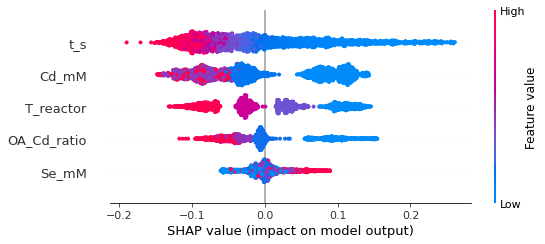

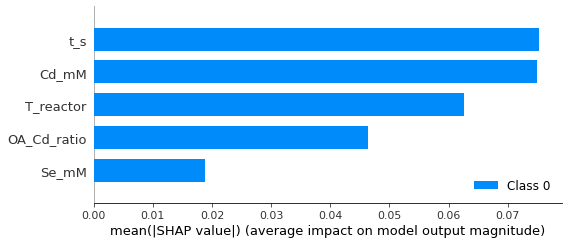

In [12]:
#SHAP on training data for Peak
import shap
explainer = shap.KernelExplainer(model_peak, background)
shap_values1 = explainer.shap_values(X)
shap.summary_plot(shap_values1[0], X)
shap.summary_plot(shap_values1, X, plot_type="bar")

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/2508 [00:00<?, ?it/s]

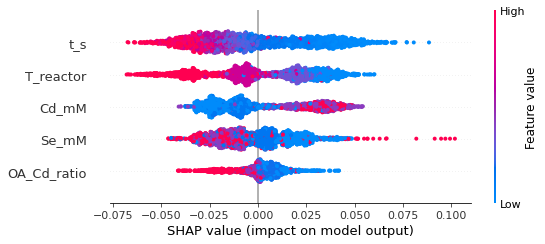

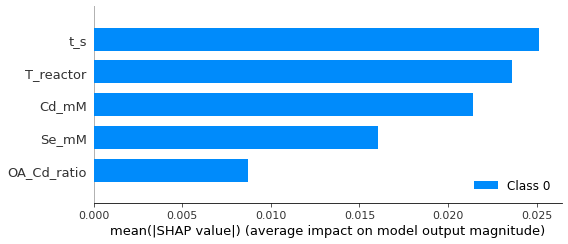

In [13]:
#SHAP on training data for FWHM
explainer = shap.KernelExplainer(model_fwhm, background)
shap_values2 = explainer.shap_values(X)
shap.summary_plot(shap_values2[0], X)
shap.summary_plot(shap_values2, X, plot_type="bar")

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/2508 [00:00<?, ?it/s]

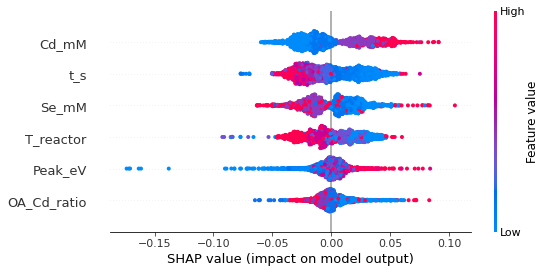

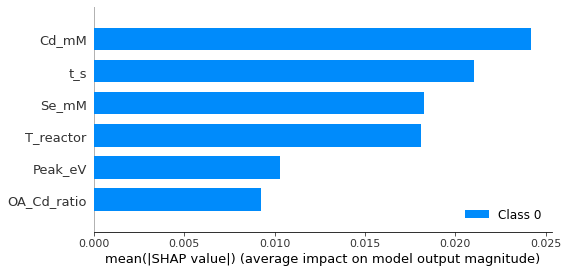

In [14]:
#SHAP on training data for FWHM (cascade)
explainer = shap.KernelExplainer(model_cascade, background2)
shap_values3 = explainer.shap_values(X2)
shap.summary_plot(shap_values3[0], X2)
shap.summary_plot(shap_values3, X2, plot_type="bar")

In [15]:
#Test NN on interpolation without dropout, UV Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe UV Test (in).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z


#prediction for Peak
y_pred = model_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = model_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", model_peak.predict(X_test), True)
y_pred_cascade = model_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Interpolation (no dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test = y_test.to_numpy().reshape(1,-1)
z_test = z_test.to_numpy().reshape(1,-1)
y_pred = y_pred.reshape(1,-1)
y_pred_fwhm = y_pred_fwhm.reshape(1,-1)
y_pred_cascade = y_pred_cascade.reshape(1,-1)

np.savetxt("NN_UV_in_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("NN_UV_in_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("NN_UV_in_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

15/15 [==============================] - 0s 2ms/step
Absorption Peak/FWHM Interpolation (no dropout at inference)
Absorbance Peak
MAE (eV):	 0.0232
R2 (eV):	 0.9625
RAE (eV):	 0.1763
RMSE (eV):	 0.0306
MAE (nm):	 4.8966
R2 (nm):	 0.9645
RAE (nm):	 0.1736
RMSE (nm):	 6.2706
Absorbance FWHM (direct)
MAE (eV):	 0.0088
R2 (eV):	 0.7393
RAE (eV):	 0.4444
RMSE (eV):	 0.0126
MAE (nm):	 1.9980
R2 (nm):	 0.7921
RAE (nm):	 0.3706
RMSE (nm):	 2.8750
Absorbance FWHM (cascade)
MAE (eV):	 0.0084
R2 (eV):	 0.7705
RAE (eV):	 0.4234
RMSE (eV):	 0.0118
MAE (nm):	 1.8772
R2 (nm):	 0.8332
RAE (nm):	 0.3482
RMSE (nm):	 2.5749


In [16]:
#Test NN on interpolation with dropout, UV Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe UV Test (in).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

X_test_t = K.constant(X_test)

#prediction for Peak
y_pred =  predict_point(X_test_t, model_peak, 1000)
#prediction for FWHM (direct)
y_pred_fwhm = predict_point(X_test_t, model_fwhm, 1000)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", y_pred, True)
X_test_t = K.constant(X_test)
y_pred_cascade = predict_point(X_test_t, model_cascade, 1000)

matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Interpolation (with dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test = y_test.to_numpy().reshape(1,-1)
z_test = z_test.to_numpy().reshape(1,-1)
y_pred = y_pred.reshape(1,-1)
y_pred_fwhm = y_pred_fwhm.reshape(1,-1)
y_pred_cascade = y_pred_cascade.reshape(1,-1)

np.savetxt("MCNN_UV_in_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("MCNN_UV_in_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("MCNN_UV_in_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Absorption Peak/FWHM Interpolation (with dropout at inference)
Absorbance Peak
MAE (eV):	 0.0231
R2 (eV):	 0.9627
RAE (eV):	 0.1756
RMSE (eV):	 0.0305
MAE (nm):	 4.8635
R2 (nm):	 0.9651
RAE (nm):	 0.1725
RMSE (nm):	 6.2180
Absorbance FWHM (direct)
MAE (eV):	 0.0088
R2 (eV):	 0.7368
RAE (eV):	 0.4437
RMSE (eV):	 0.0126
MAE (nm):	 2.0121
R2 (nm):	 0.7848
RAE (nm):	 0.3732
RMSE (nm):	 2.9253
Absorbance FWHM (cascade)
MAE (eV):	 0.0081
R2 (eV):	 0.7883
RAE (eV):	 0.4091
RMSE (eV):	 0.0113
MAE (nm):	 1.8058
R2 (nm):	 0.8436
RAE (nm):	 0.3349
RMSE (nm):	 2.4933


In [17]:
#Test Linear model on extrapolation, UV Peak, FWHM (eV)

#Test data set (extrapolation)
df2 = pd.read_csv('CdSe UV Test (out).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = model_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = model_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", model_peak.predict(X_test), True)
y_pred_cascade = model_cascade.predict(X_test)

matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Extrapolation (no dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test = y_test.to_numpy().reshape(1,-1)
z_test = z_test.to_numpy().reshape(1,-1)
y_pred = y_pred.reshape(1,-1)
y_pred_fwhm = y_pred_fwhm.reshape(1,-1)
y_pred_cascade = y_pred_cascade.reshape(1,-1)

np.savetxt("NN_UV_out_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("NN_UV_out_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("NN_UV_out_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

12/12 [==============================] - 0s 911us/step
Absorption Peak/FWHM Extrapolation (no dropout at inference)
Absorbance Peak
MAE (eV):	 0.0591
R2 (eV):	 0.8306
RAE (eV):	 0.3569
RMSE (eV):	 0.0819
MAE (nm):	 12.9030
R2 (nm):	 0.8061
RAE (nm):	 0.3643
RMSE (nm):	 18.4339
Absorbance FWHM (direct)
MAE (eV):	 0.0262
R2 (eV):	 -0.3754
RAE (eV):	 0.9706
RMSE (eV):	 0.0370
MAE (nm):	 5.9202
R2 (nm):	 -2.0911
RAE (nm):	 1.3114
RMSE (nm):	 9.2440
Absorbance FWHM (cascade)
MAE (eV):	 0.0242
R2 (eV):	 0.0745
RAE (eV):	 0.8946
RMSE (eV):	 0.0304
MAE (nm):	 5.7218
R2 (nm):	 -1.3542
RAE (nm):	 1.2675
RMSE (nm):	 8.0672


In [18]:
#Test NN on interpolation with dropout, UV Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe UV Test (out).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

X_test_t = K.constant(X_test)

#prediction for Peak
y_pred =  predict_point(X_test_t, model_peak, 1000)
#prediction for FWHM (direct)
y_pred_fwhm = predict_point(X_test_t, model_fwhm, 1000)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", y_pred, True)
X_test_t = K.constant(X_test)
y_pred_cascade = predict_point(X_test_t, model_cascade, 1000)

matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Extrapolation (with dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test = y_test.to_numpy().reshape(1,-1)
z_test = z_test.to_numpy().reshape(1,-1)
y_pred = y_pred.reshape(1,-1)
y_pred_fwhm = y_pred_fwhm.reshape(1,-1)
y_pred_cascade = y_pred_cascade.reshape(1,-1)

np.savetxt("MCNN_UV_out_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("MCNN_UV_out_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("MCNN_UV_out_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Absorption Peak/FWHM Extrapolation (with dropout at inference)
Absorbance Peak
MAE (eV):	 0.0590
R2 (eV):	 0.8313
RAE (eV):	 0.3562
RMSE (eV):	 0.0817
MAE (nm):	 12.9503
R2 (nm):	 0.8033
RAE (nm):	 0.3657
RMSE (nm):	 18.5676
Absorbance FWHM (direct)
MAE (eV):	 0.0258
R2 (eV):	 -0.3211
RAE (eV):	 0.9536
RMSE (eV):	 0.0363
MAE (nm):	 5.8230
R2 (nm):	 -1.9263
RAE (nm):	 1.2899
RMSE (nm):	 8.9942
Absorbance FWHM (cascade)
MAE (eV):	 0.0257
R2 (eV):	 -0.0607
RAE (eV):	 0.9509
RMSE (eV):	 0.0325
MAE (nm):	 6.0696
R2 (nm):	 -1.6185
RAE (nm):	 1.3445
RMSE (nm):	 8.5080
